# 1. Dataset Description
- This dataset, collected by data scientists at BigMart is the 2013 sales data for 1559 products across 10 stores in different cities.
- Number of tuples: 8523

## 1.1 Different features in the dataset:
- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or not
- Item_Visibility: The % of the total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which the store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of city in which the store is located
- *Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
- Item_Outlet_Sales: sales of the product in the particular store. This is the outcome variable to be predicted.


# 2. Packages and Data

Importing all the necessary packages

In [352]:
# For linear algebra
import numpy as np
# For data processing
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns

# imputes missing values by predicting the missing values using K-nearest neighbour appraoch
from sklearn.impute import KNNImputer

# Label Encoder encodes categorical values to numerical labels. Example, {"cat", "dog"} -> {1, 2};
# PolynomialeFeatures is used to generate polynomial features from input data. Used to model non-linear relationships in Linear Regression.
# StandardScalar is used to normalize data. i.e to normalize all different types of features to the same scale.
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

# Used to combine data processing and model training to a single workflow.
from sklearn.pipeline import Pipeline

# ElasticNet is used to regularize Linear model to avoid overfitting data or irrelavant features.
# Lasso shrinks less important features to zero for simpler model.
# Reduces the impact of large irrelavant coefficients. i.e. Avoids model from being sensitive to outliers.
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(42)

Mounting Google drive. And, loading the dataset.

In [353]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [354]:
DRIVE_FOLDER_LOCATION = '/content/drive/MyDrive/sales-prediction'

In [355]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  import os
  if os.path.isdir(DRIVE_FOLDER_LOCATION) == False:
    os.makedirs(DRIVE_FOLDER_LOCATION)
    print("Directory" + DRIVE_FOLDER_LOCATION + " did not exist but was created.")

    os.chdir(DRIVE_FOLDER_LOCATION)
    print("Working directory changed to: " + DRIVE_FOLDER_LOCATION)



In [356]:
train = pd.read_csv(DRIVE_FOLDER_LOCATION + "/train.csv")

## Exploring the Dataset

In [357]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [358]:
train.shape

(8523, 12)

Here, we can see that our dataset has 8523 tuples with 12 features.

Checking Datatypes of each features

In [359]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item Identifier is a unique id of each item. So, this is not a relevant data so, we will drop it later.
Now, we will analyze the summary of statistics (min, max, mean, etc..) for all of our columns.

In [360]:
train.describe(include="all")

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [361]:
# Now, getting the number of missing datapoints per column
train.isnull().sum().sort_values(ascending=False)

,0
Outlet_Size,2410
Item_Weight,1463
Item_Identifier,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Location_Type,0


Here, we can see that the column Outlet_Size has 2410 missing values.

And, Item_Weight has 1463 missing values.

Now, we have to either drop all of them or we can do some analysis and fill the missing values. Dropping 2410 i.e. 28% of out total data items is not a good idea.

In [362]:
train.Outlet_Establishment_Year

,Outlet_Establishment_Year
0,1999
1,2009
2,1999
3,1998
4,1987
...,...
8518,1987
8519,2002
8520,2004
8521,2009


The oldest outlet was established in 1985 and the newest in 2009.
So, We could convert this column into a categorical variable by grouping the outlets into categories based on their establishment years, such as 1985-1990, 1991-2000, and so on. Or, we can simply calculate their age to convert into more relavant numeric attribute.

# 3. Exploratory Data Analysis (EDA)

## 3.1 Univariate Analysis

### 3.1.1 Numeric Features

In [363]:
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [364]:
numeric_columns

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [365]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


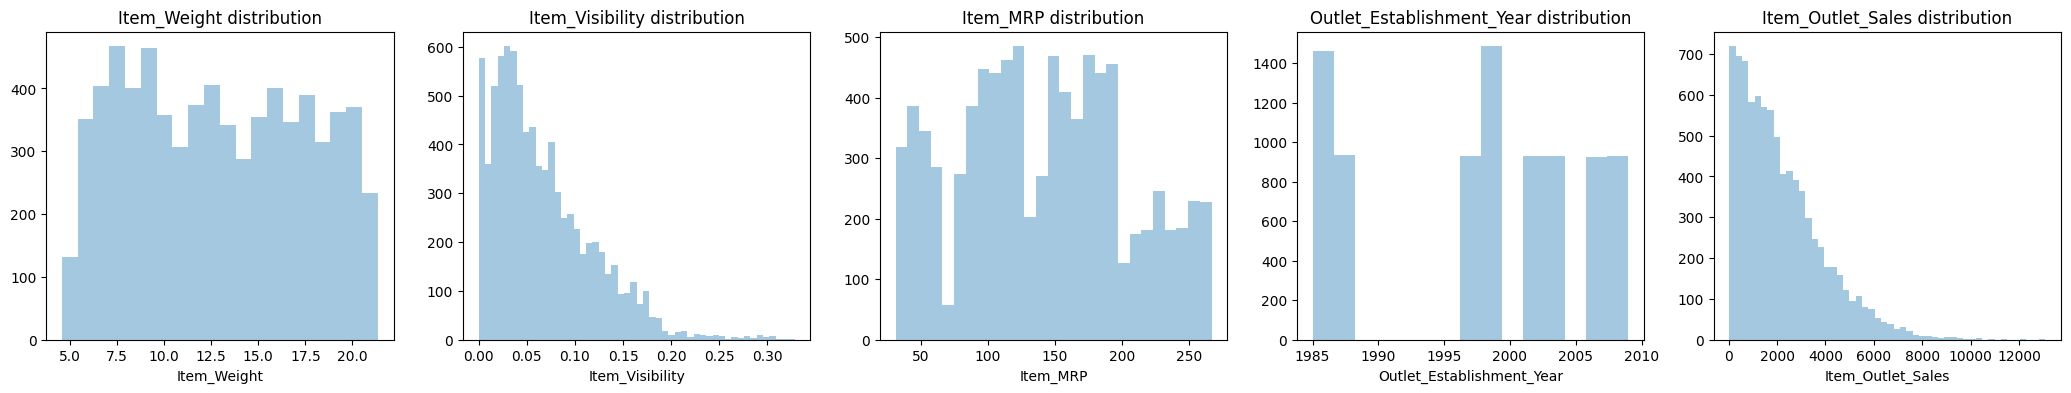

In [366]:
# Distribution plot for our dataset
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_columns):
    sns.distplot(train[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

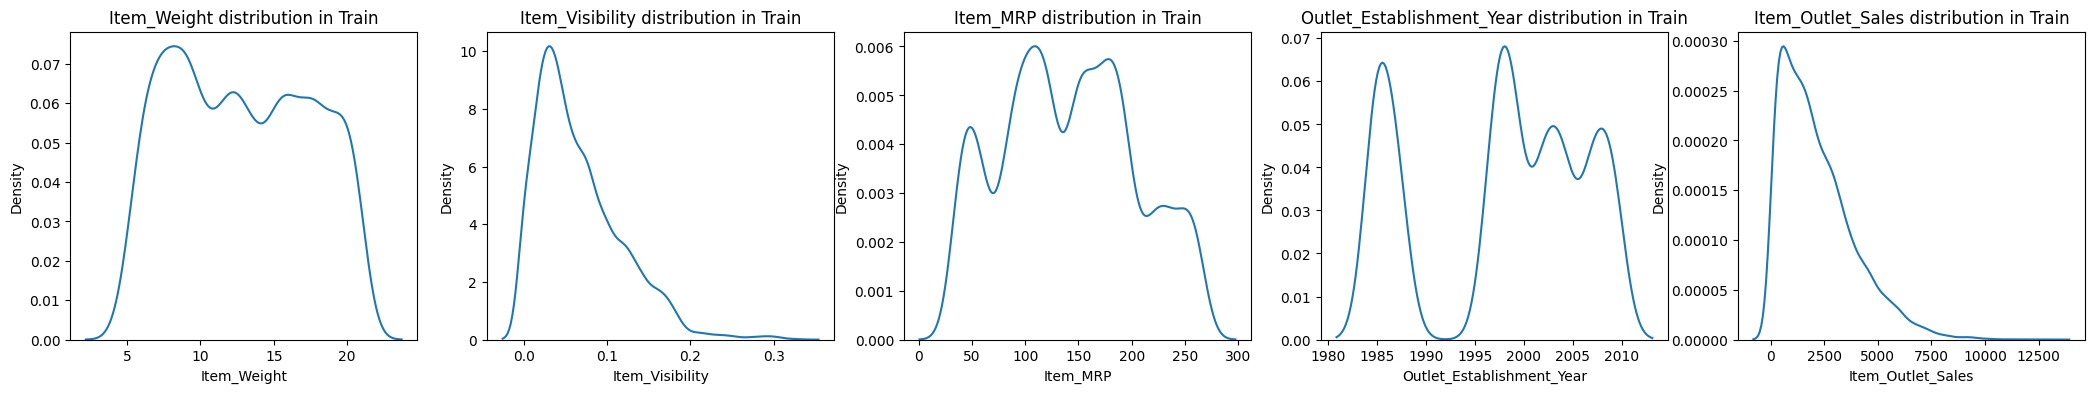

In [367]:
# KDE plot
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_columns):
    sns.kdeplot(data=train, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

Observations:
- Item weight ranges from 5 Kg to 20 Kg.
- Item visibility is right skewed.
- There are more products in the range of 100 MRP - 180 MRP in the Item_MRP feature
- Lots of stores have been established in the years 1985, 1998 etc... and there was no store establishment between 1990 and 1995.
- Item_Outlet_Sales feature is right skewed. We can may be try to do a transformation in order to obtain a normal or Gaussian distribution

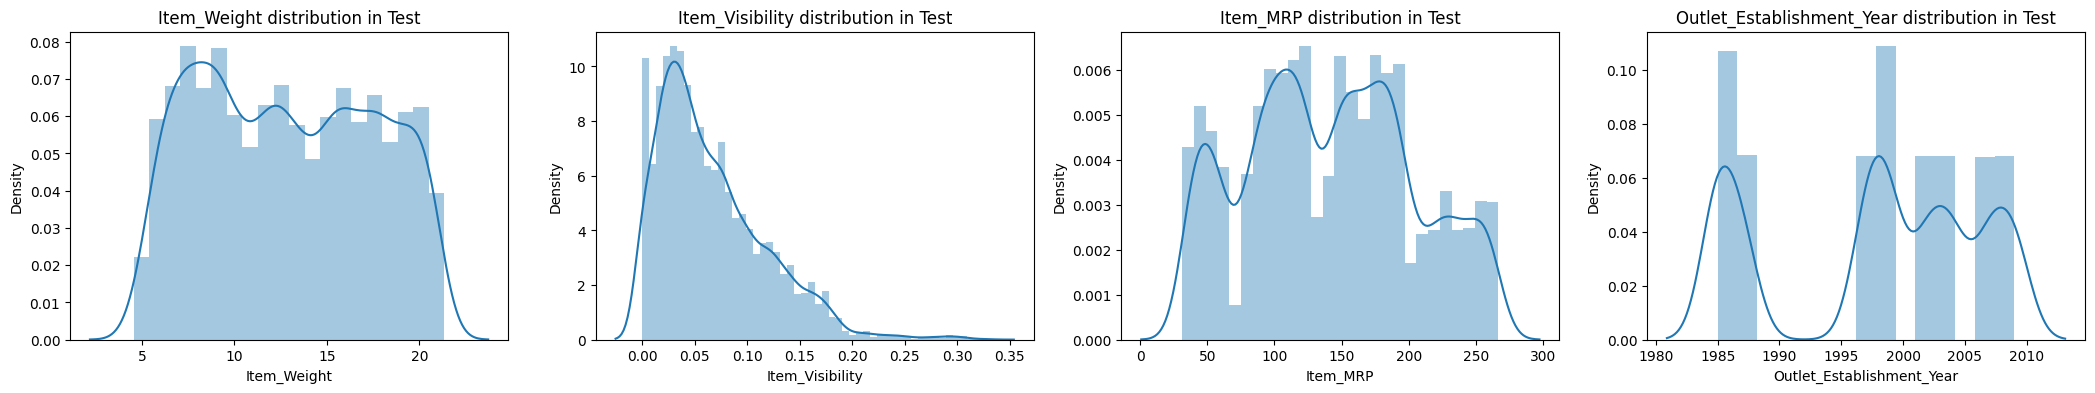

In [368]:
# Combined plot
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']):
    sns.distplot(train[col], kde=True, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test')

Box plot analysis to identify outliers:

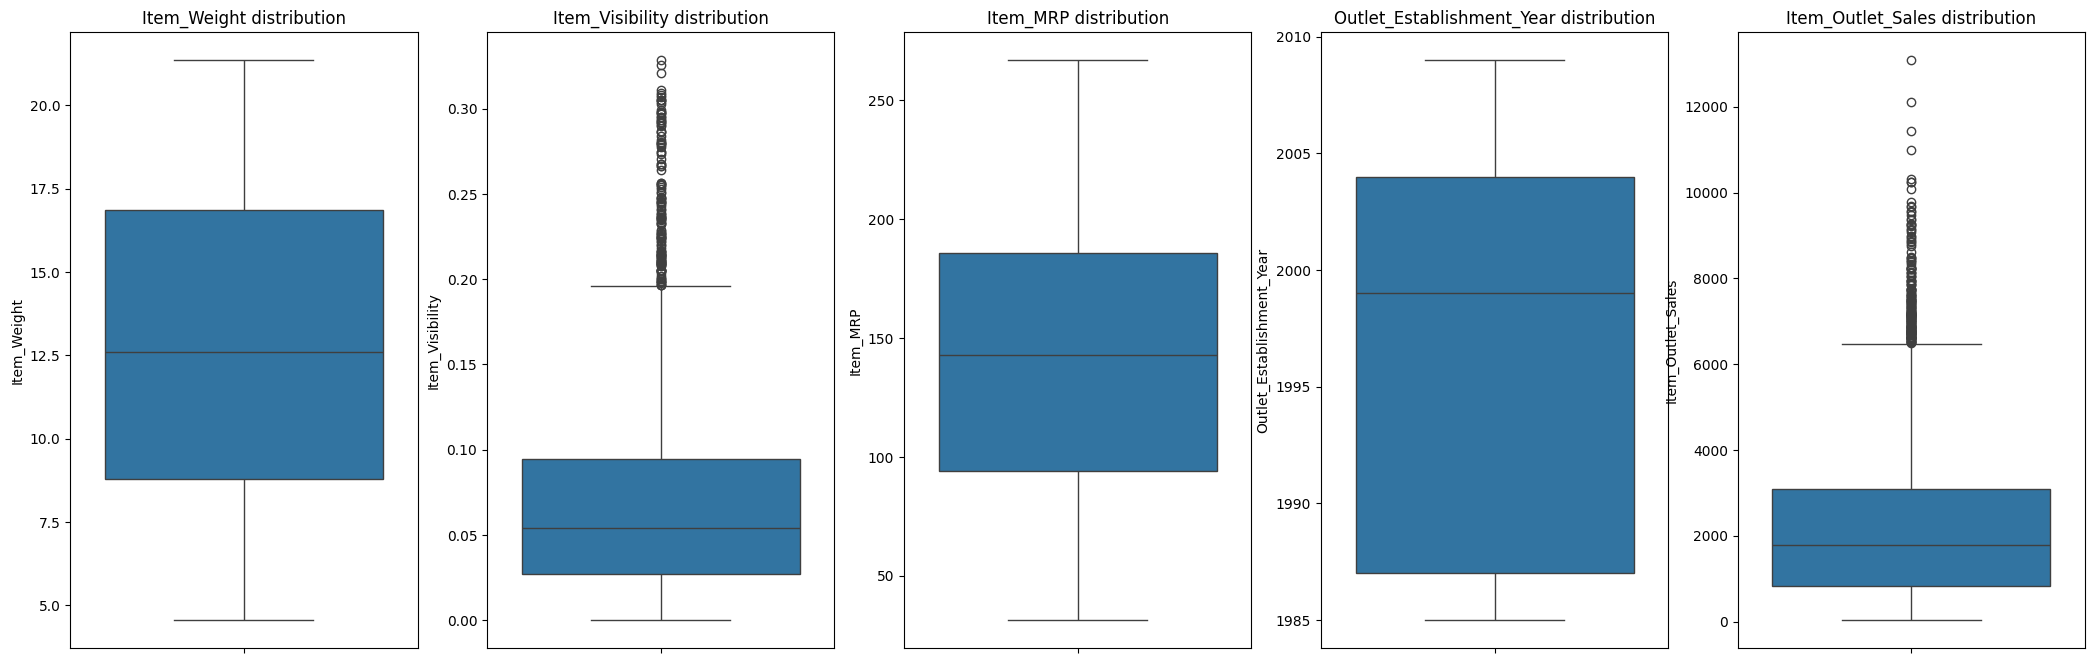

In [369]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_columns):
    sns.boxplot(data=train, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

Observations:

- There are no outliers in the Item_Weight, Item_MRP and Outlet_Establishment_Year features.
- But, there are some outliers to be removed in the Item_Visibility and Item_Outlet_Sales features.


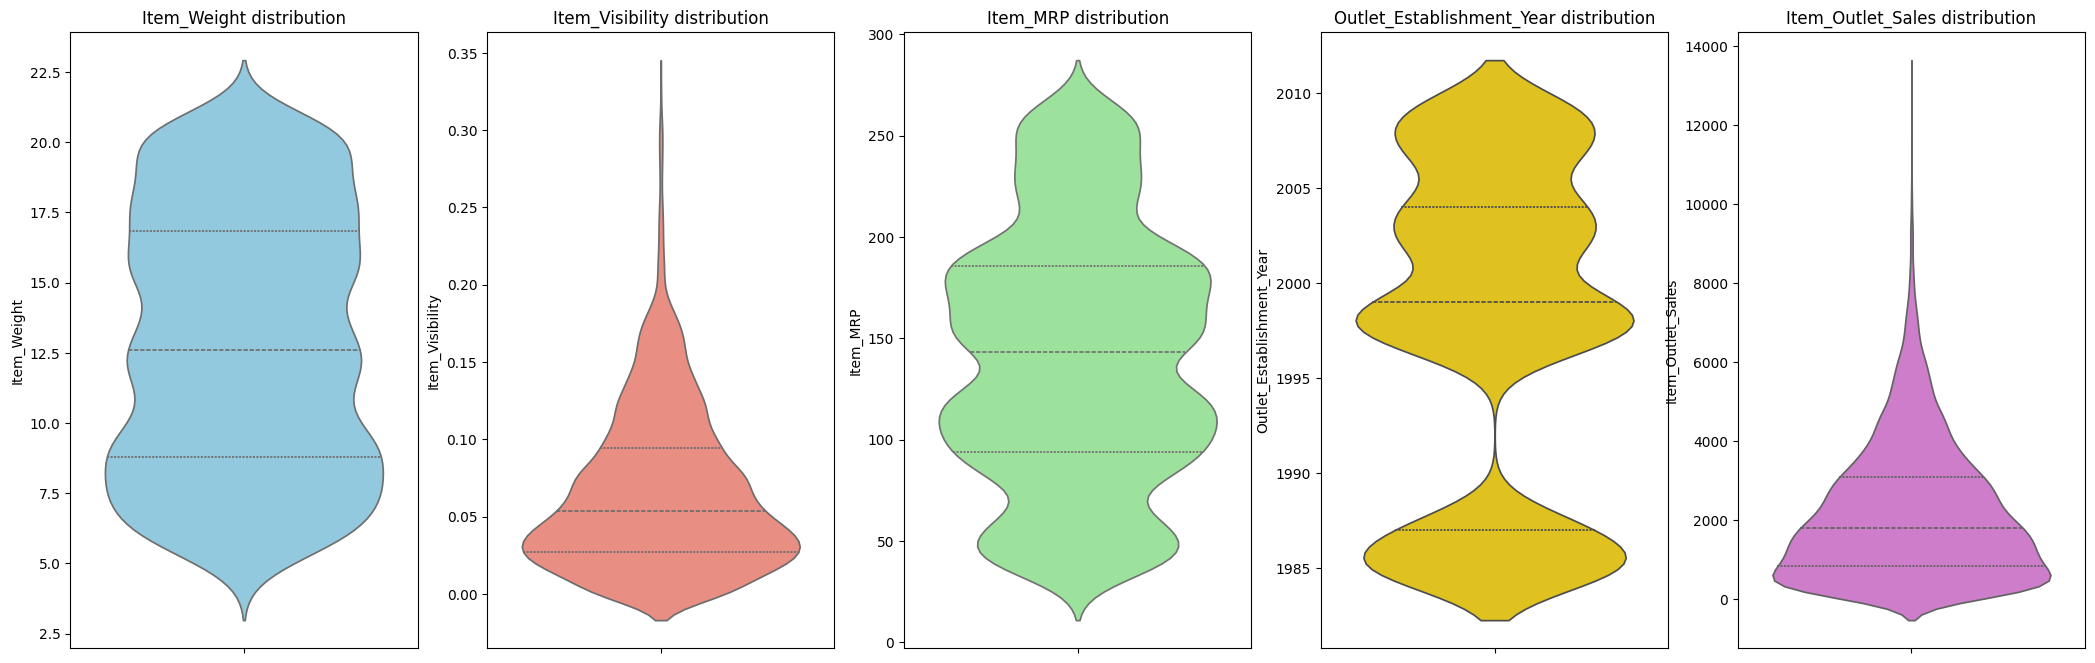

In [370]:
# Violin plot
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'orchid']
for index, col in enumerate(numeric_columns):
    sns.violinplot(data=train, y=col, ax=ax[index], inner='quartile', color=colors[index])
    ax[index].set_title(f'{col} distribution')

Main Observation and conclusion: Item Visibility and Item Outlet Sales have some outliers to be filtered.

### 3.1.2 Categorical Features

In [371]:
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [372]:
categorical_cols_to_display = [
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64
------------

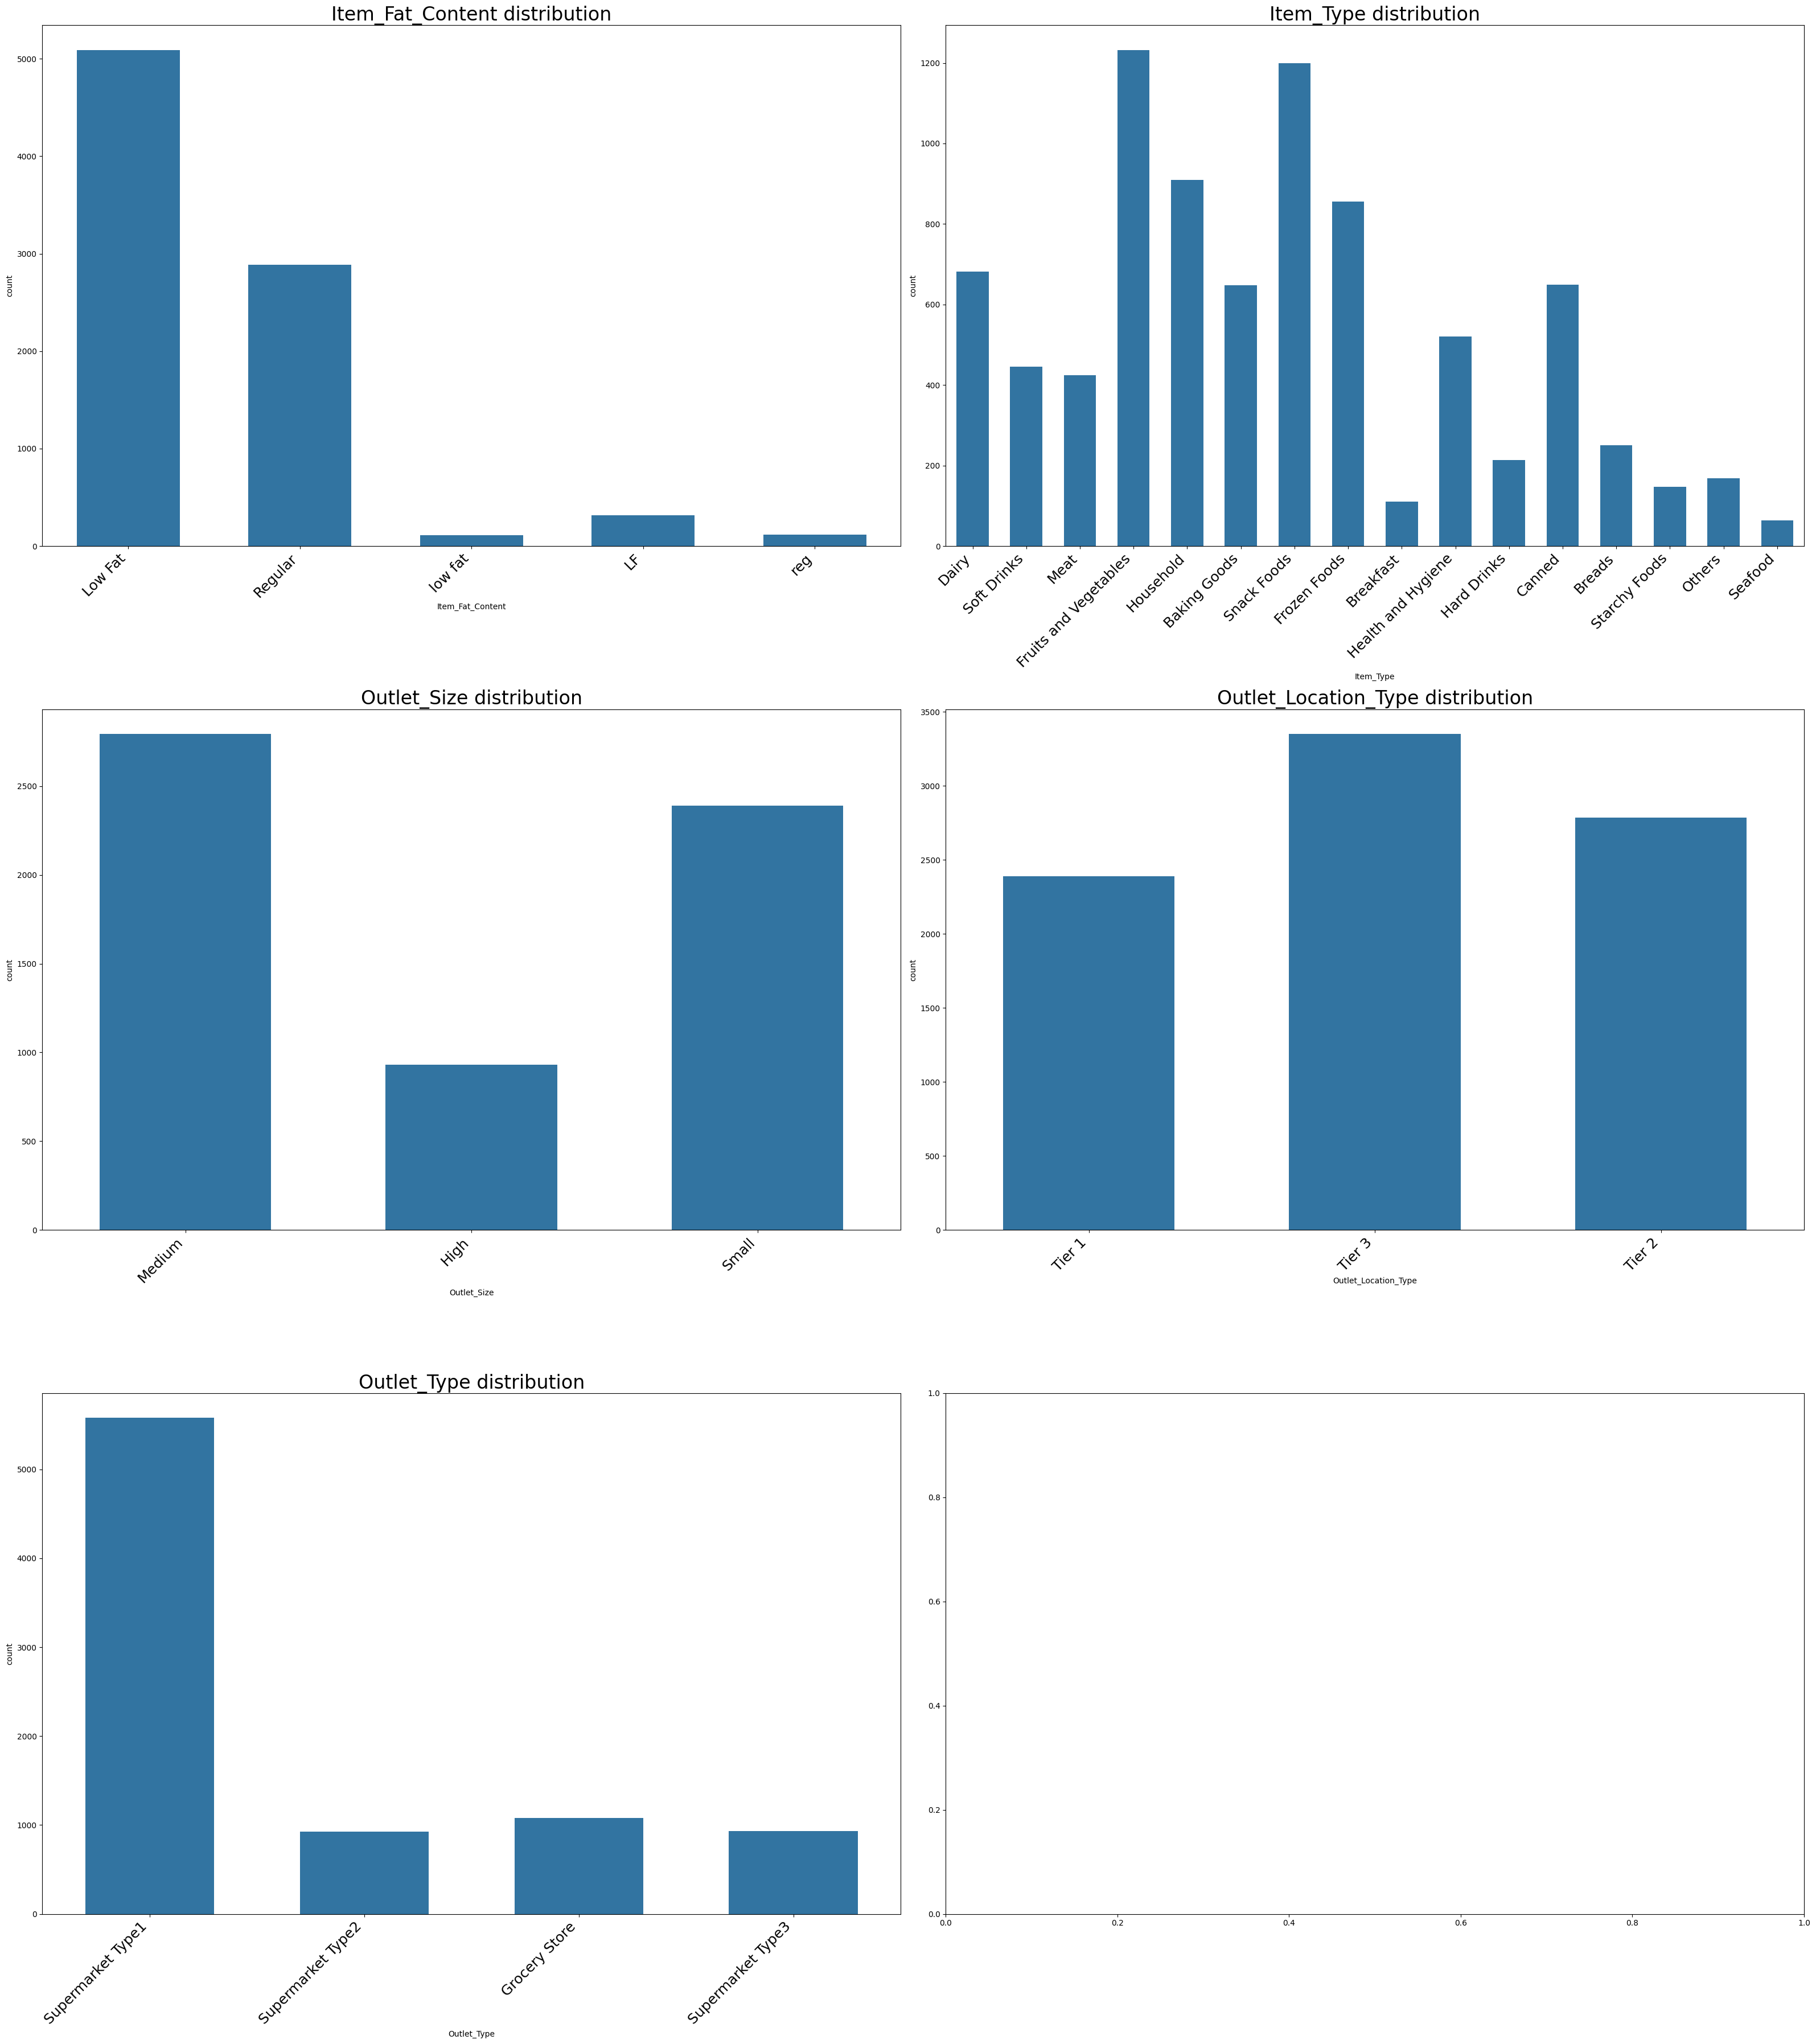

In [373]:
# Count plot for all different values of categorical attributes
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=train, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

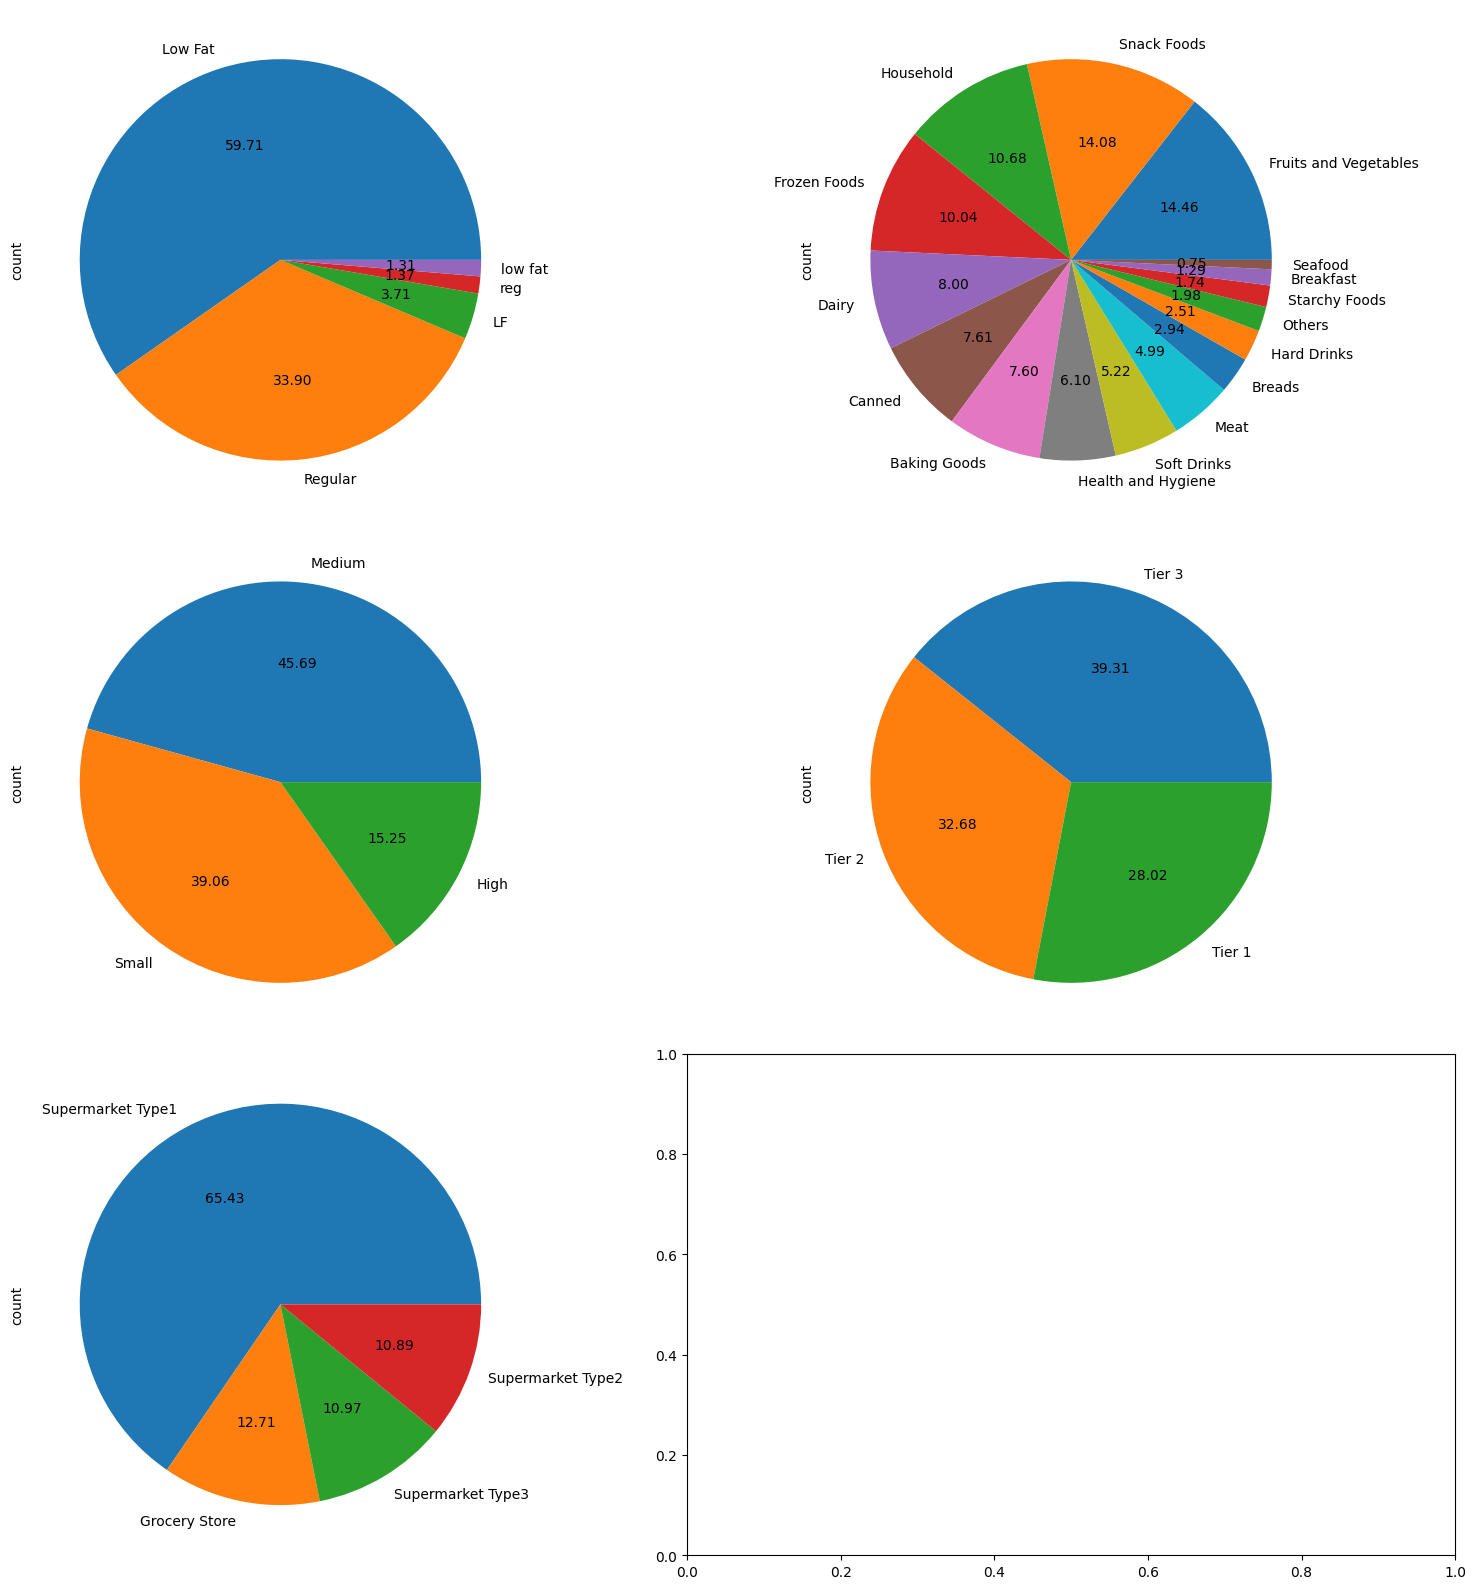

In [374]:
# Pie Chart for clearer visualization
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    train[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    plt.tight_layout()

Observations:
- 'Low Fat', 'low fat' and 'LF' should be the same category
- Similarly 'Regular' and 'reg' should also be the same.
- There are 16 different categories in the the Item_type feature.
- This is a lot. So, we can try to group them into categories during feature engineering. Example:
  - 'Soft Drinks' and 'Hard Drinks' into a 'Drinks' category or
'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' into a 'Foods' category.
- We will encode the Outlet_Location_Type feature, as below:

  - 'Tier 1' ---> 1
  - 'Tier 2' ---> 2
  - 'Tier 3' ---> 3

## 3.2 Bi-variate Analysis

### 3.2.1 Numerical-Numerical

In [375]:
target = "Item_Outlet_Sales"

**Scatter Plots**

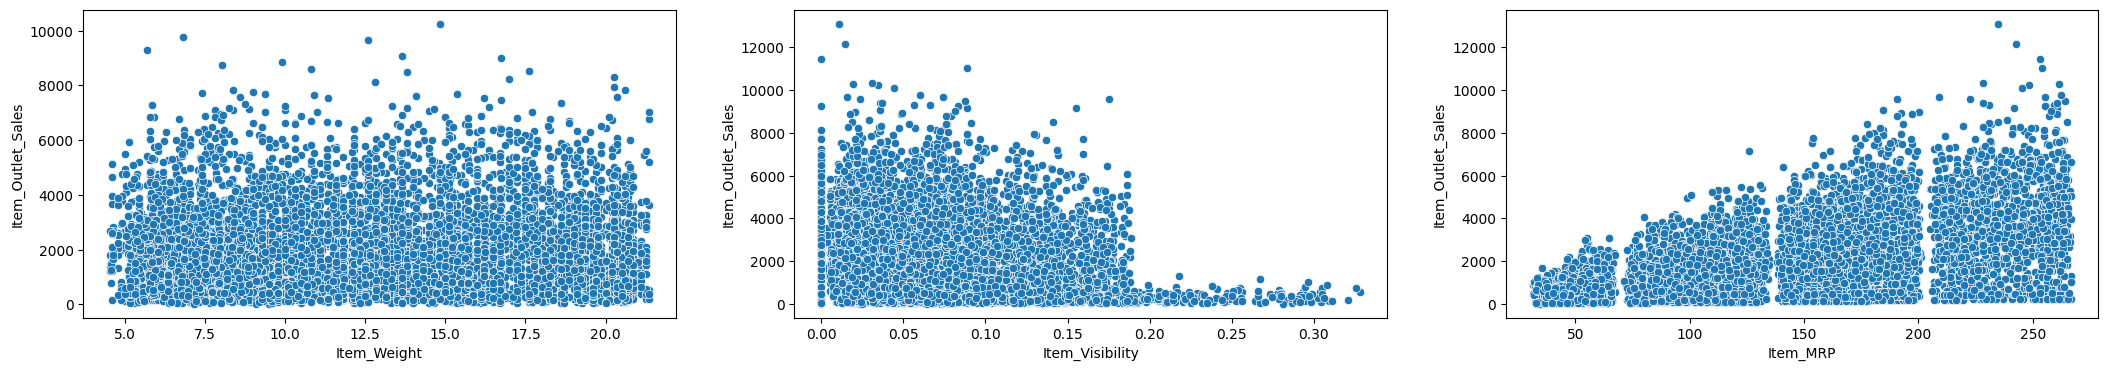

In [376]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index])
    #ax[index].set_title(f'{col} distribution')

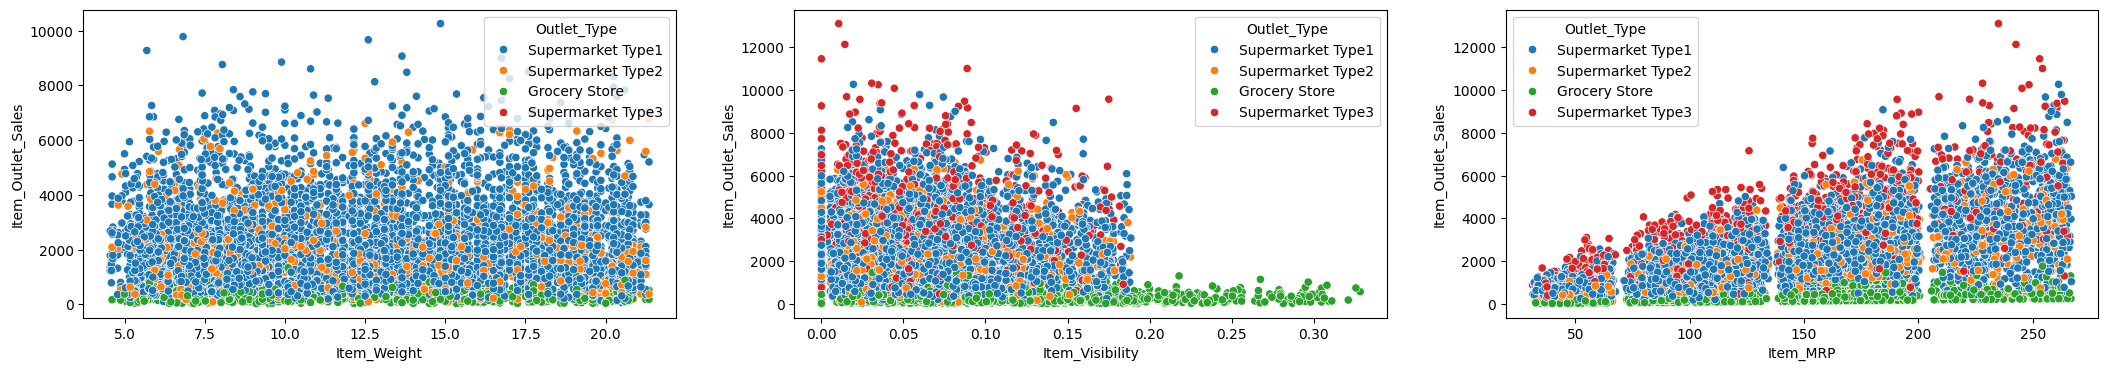

In [377]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index], hue='Outlet_Type')

In [378]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


<Axes: >

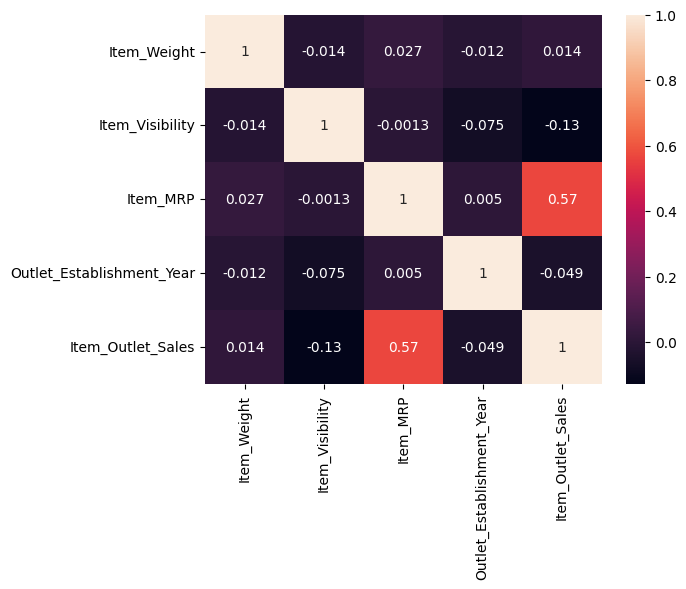

In [379]:
sns.heatmap(train.select_dtypes(include=['float64', 'int64']).corr(), annot=True)

Observation:
- There is a correlation of 0.57 (which is the highest among all the other numeric features) between Item_MRP and Item_Outlet_Sales(target) which indicates a moderate positive relationship, meaning that, in general, as the Item MRP (the price of the item) increases, the Item Outlet Sales (the sales of the item) also tend to increase.

### 3.2.2 Numerical-Categorical

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

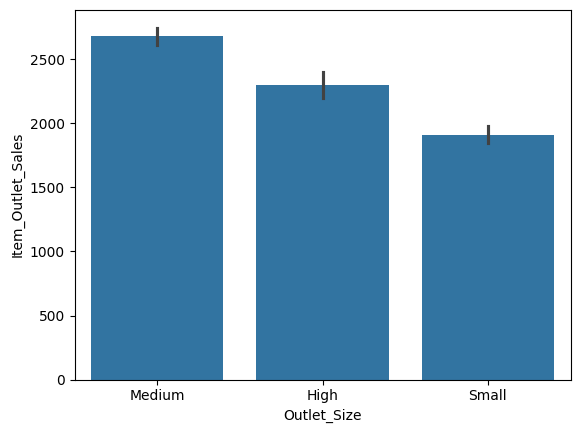

In [380]:
sns.barplot(data=train, x='Outlet_Size', y=target)

# 4. Handling Missing Values

What we have observed till now is that Outlet_Size is a categorical feature.  So, we will be using mode to fill in the missing values.

On the other hand, item weight is a numeric column, and also there are no any outliers as we can clearly see in the plot. So, we will be using mean to replace the missing values.

In [381]:
#filling the object values with mode and float type with mean

# for train
train['Outlet_Size'] = train.Outlet_Size.fillna(train.Outlet_Size.dropna().mode()[0])
train['Item_Weight'] = train.Item_Weight.fillna(train.Item_Weight.mean())


In [382]:
train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


Here, now, we have handled all the missing values.

# 5. Feature Engineering

Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


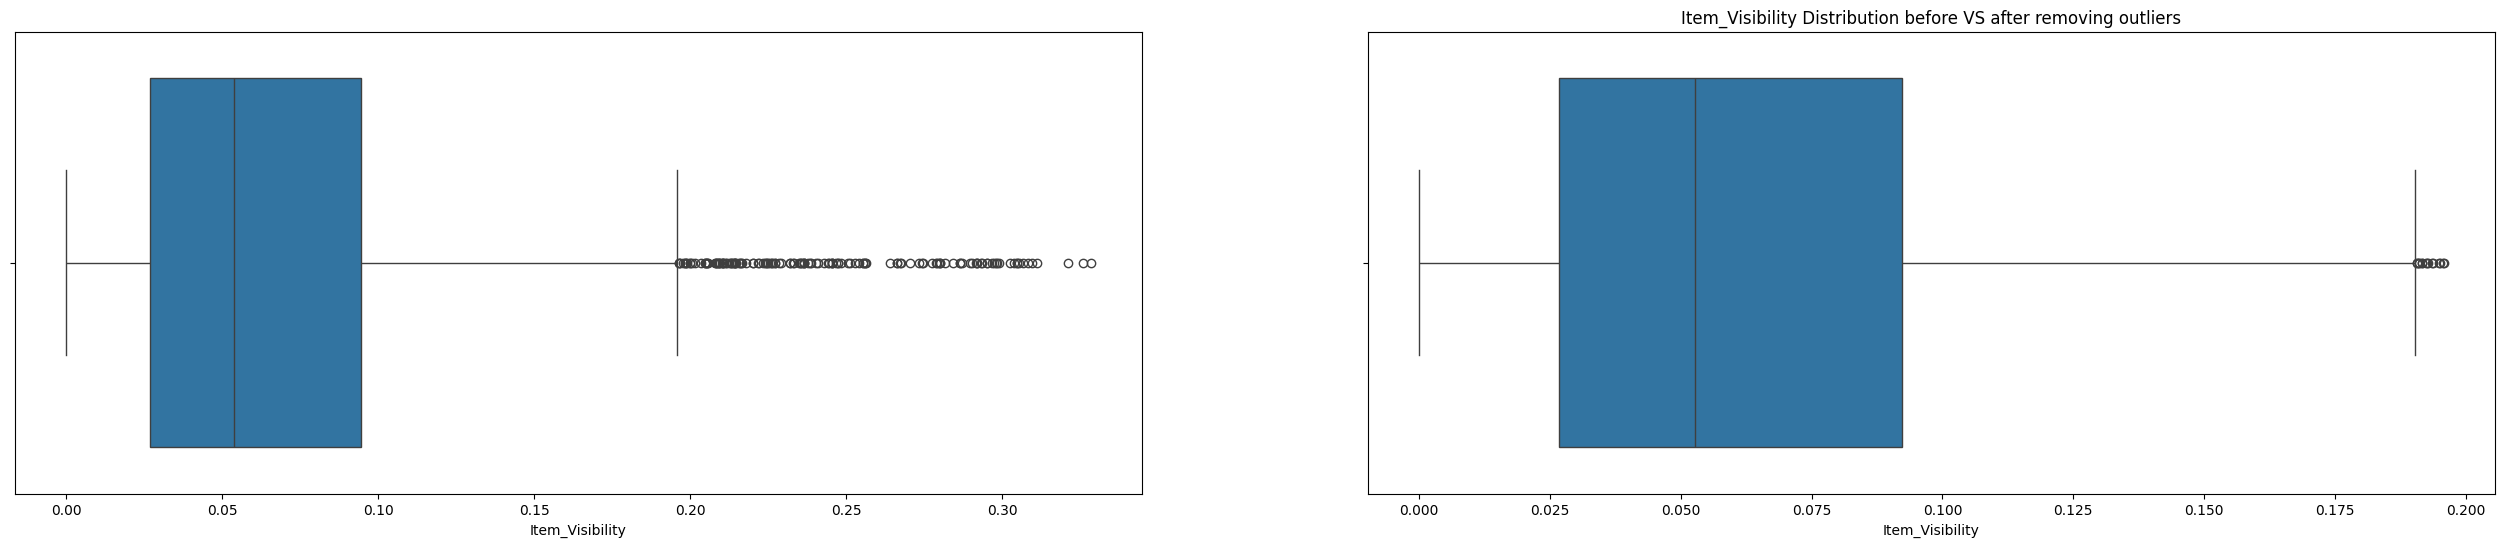

In [383]:
# The function below detects outliers using the IQR method.
# This means it will remove all the data having vales greater than upper limit or less than lower limit.
def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
train = train[(train['Item_Visibility'] > lower) & (train['Item_Visibility'] < upper)] #train

sns.boxplot(x=train['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


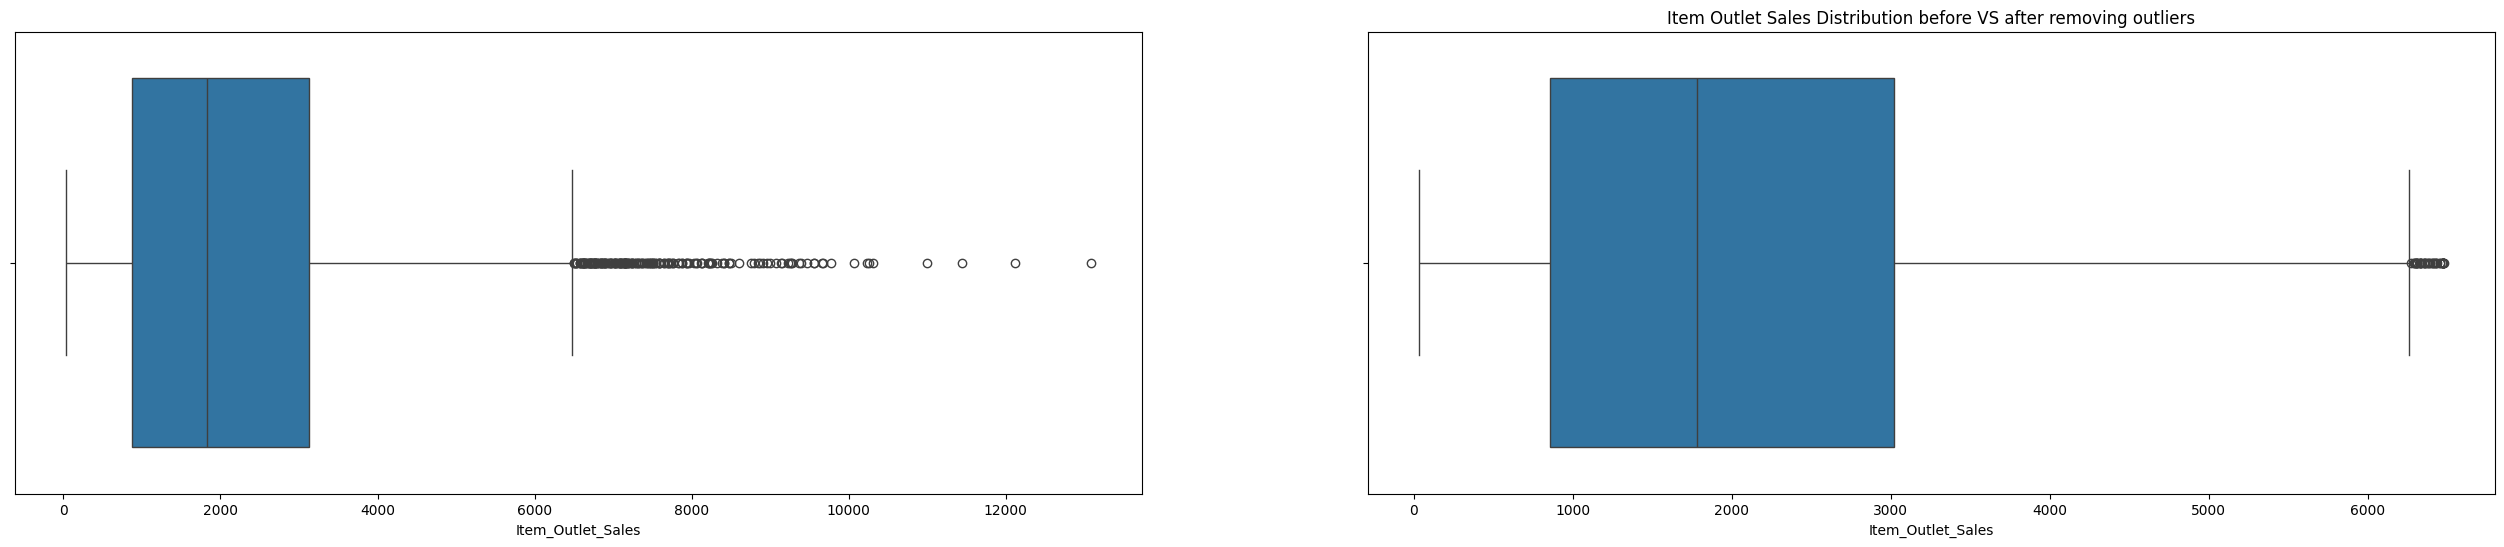

In [384]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(train, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[0])

# removing outliers using the same function
train = train[(train['Item_Outlet_Sales'] > lower) & (train['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

Now, we will be correcting the labels in item fat content as well. i.e. replacing LF by Low fat and so on.

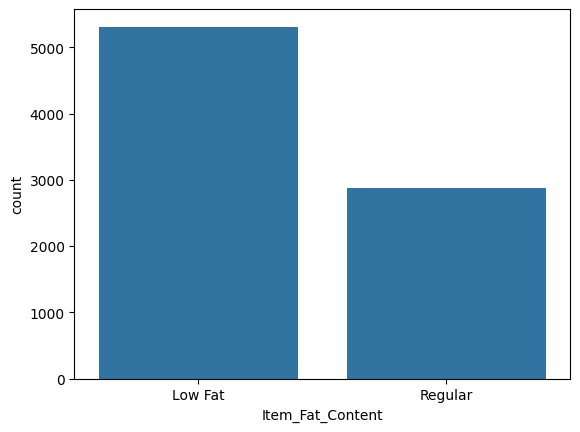

In [385]:
# Let's correct the errors in the Item_Fat_Content column

train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })


sns.countplot(x=train['Item_Fat_Content']);


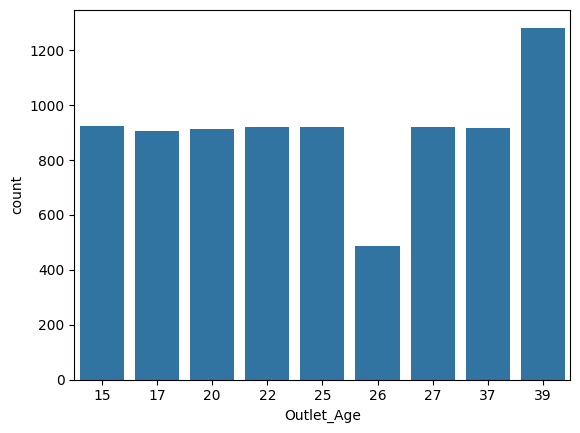

In [386]:
# getting the amount of established years in new column and deleting old column
train['Outlet_Age'] = 2024 - train['Outlet_Establishment_Year']
del train['Outlet_Establishment_Year']

sns.countplot(x=train['Outlet_Age']);

## 5.1 Encoding Categorical values

### 5.1.1 Label Encoding

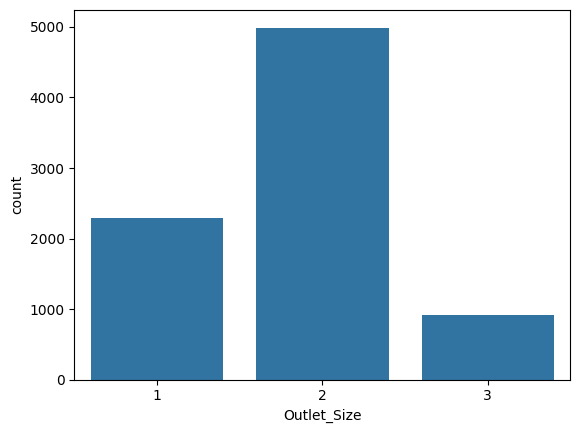

In [387]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)


sns.countplot(x=train['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

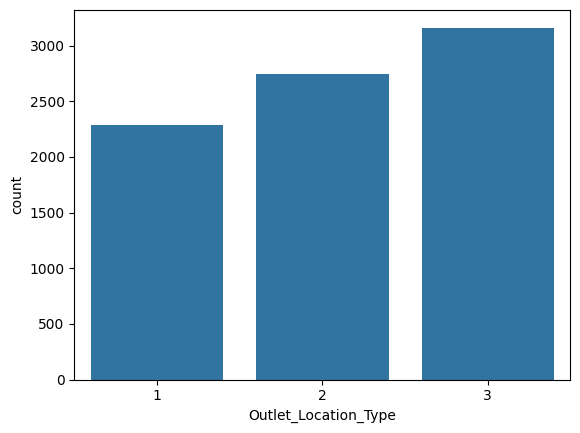

In [388]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type

train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train['Outlet_Location_Type'])

In [389]:
train.Item_Type

,Item_Type
0,Dairy
1,Soft Drinks
2,Meat
3,Fruits and Vegetables
4,Household
...,...
8518,Snack Foods
8519,Baking Goods
8520,Health and Hygiene
8521,Snack Foods


- In the Item_Type feature, there are 16 categories but when we look closely to Item_Identifier_Categories, it has first two characters defining the item type, these are:

  - FD for probably Food;
  - DR for probably Drinks;
  - NC for probably Non-Consumables.
  - So we'll drop the Item_Identifier feature and create a new column containing these categories.

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

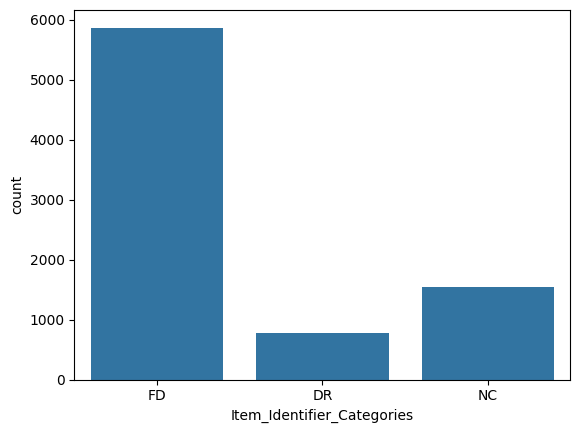

In [390]:
train['Item_Identifier_Categories'] = train['Item_Identifier'].str[0:2]

sns.countplot(x=train['Item_Identifier_Categories'])

In [391]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380,25,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,3,Supermarket Type2,443.4228,15,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700,25,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,Grocery Store,732.3800,26,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,3,3,Supermarket Type1,994.7052,37,NC


In [392]:
# #Label Encoder for Ordinate Data

# encoder = LabelEncoder()
# ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

# for feature in ordinal_features:
#     train[feature] = encoder.fit_transform(train[feature])

# train.shape

In [393]:
from sklearn.preprocessing import LabelEncoder

# Define the features to encode
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

# Dictionary to store encoders for each feature
encoders = {}

for feature in ordinal_features:
    encoder = LabelEncoder()
    train[feature] = encoder.fit_transform(train[feature])
    encoders[feature] = encoder  # Store the encoder for later use

    # Print the mapping for each feature
    print(f"Mapping for {feature}:")
    print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))  # Display category -> encoding
    print()

# Shape of the modified train data
print(f"Train shape: {train.shape}")


Mapping for Item_Fat_Content:
{'Low Fat': 0, 'Regular': 1}

Mapping for Outlet_Type:
{'Grocery Store': 0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}

Mapping for Outlet_Location_Type:
{1: 0, 2: 1, 3: 2}

Train shape: (8193, 13)


In [394]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,2,0,1,3735.1380,25,FD
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,2,2,443.4228,15,DR
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,2,0,1,2097.2700,25,FD
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,2,0,732.3800,26,FD
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,3,2,1,994.7052,37,NC


### 5.1.2 One Hot Encoding

In [395]:
# One Hot Encoding for 'Item_Type' variable
# We will also be deleting 'Item Type' feature now, as it will be covered by 'Item_Identifier_Categories' and we don't want
# to increase dimensionality.
# Also, we want to predict, how a particular product will perform on particular type of outlet and not necessarily a particular outlet.
# So, we will also drop Outlet identifier.

del train['Item_Type']
del train['Outlet_Identifier']

# train = pd.get_dummies(train, columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)
train = pd.get_dummies(train, columns=['Item_Identifier_Categories'], drop_first=False)

In [396]:

train.shape

(8193, 13)

In [397]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,FDA15,9.30,0,0.016047,249.8092,2,0,1,3735.1380,25,False,True,False
1,DRC01,5.92,1,0.019278,48.2692,2,2,2,443.4228,15,True,False,False
2,FDN15,17.50,0,0.016760,141.6180,2,0,1,2097.2700,25,False,True,False
3,FDX07,19.20,1,0.000000,182.0950,2,2,0,732.3800,26,False,True,False
4,NCD19,8.93,0,0.000000,53.8614,3,2,1,994.7052,37,False,False,True


### 5.1.3 Final Data Preprocessing

In [398]:
# Dropping Useless Columns
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)

In [399]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [400]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,9.30,0,0.016047,249.8092,2,0,1,25,False,True,False
1,5.92,1,0.019278,48.2692,2,2,2,15,True,False,False
2,17.50,0,0.016760,141.6180,2,0,1,25,False,True,False
3,19.20,1,0.000000,182.0950,2,2,0,26,False,True,False
4,8.93,0,0.000000,53.8614,3,2,1,37,False,False,True


In [401]:
y.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


In [286]:
# splitting into training set and test set 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# 6. Training Models

## 6.1 Linear Regression

In [287]:
X_train.dtypes

,0
Item_Weight,float64
Item_Fat_Content,int64
Item_Visibility,float64
Item_MRP,float64
Outlet_Size,int64
Outlet_Location_Type,int64
Outlet_Type,int64
Outlet_Age,int64
Item_Identifier_Categories_DR,bool
Item_Identifier_Categories_FD,bool


In [288]:
print(X_train.shape)
print(X.shape)
print(train.shape)

(6554, 11)
(8193, 11)
(8193, 12)


In [289]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [290]:
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

In [291]:
print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

Training score  : 0.4870700886880204
Test score      : 0.48258589160563425


In [101]:
# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1091.9440742248269
R2 Score         ----> 0.48258589160563425


- Here, our LinearRegression model above give us a training accuracy of 48.70% and a test accuracy of about 48.25%. We also get an RMSE of 1091.944 and a R2 score of 0.4825.
- Now, we will try to add some polynomial features to see how good the Linear Regression performs.
- Also, standardizing our data so that our data scales down to a range between 0 and 1. This serves the purpose of letting us work with reasonable numbers when we raise to a power.

In [106]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.5768539543443774
Test score      : 0.5686364136857096


The training score increased to 57.68%, and the test score also increased to 56.86%, which suggests that degree 2 polynomial regression is better than degree 1 linear regression.

Now, trying for 3 degree:

In [108]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=4)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.613969886605873
Test score      : 0.5643533961783922


- Here, the training score increased to 59.7% and test score to 57.76%. This suggests early sign of overfitting but is still better than 2 degree.
- We also experimented with degree 4 and found that Training score increased to 61.39% but test score decreased to 56.43%. So, increasing degree more than 3 will make the model overfit. So, we will be using degree 3, and regularizing.

### 6.1.1 Ridge Regression or l2 Regularization

During gradient descent, when our model coefficients are trained, our initial weights are updated according to a gradient update rule using a learning rate and a gradient.

Ridge regression adds a penalty to the update, and as a result shrinks the size of our weights. This is implemented in scikit-learn as a class called Ridge.
We will specify our regularization strength by passing in a parameter, alpha. The larger the value of alpha, the less variance our model will exhibit.

For degree-3:

with alpha = 10

In [116]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=3)),
            ('model' , Ridge(alpha=10, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Training Score  : 0.5970656762261615
Test Score      : 0.577706773670373


We experimented with different values of alpha, but the training score is stable around 59.7% without overfittinig and the best test score is 57.77% which is not much better than as compared to 3-degree linear regression without regularization.

So, we will be continuing with this benchmark.

In [117]:
ridge_predictions = ridge_pipeline.predict(X_test)

In [118]:
# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

Ridge RMSE  	         ----> 986.4800805549054
Ridge R2 Score         ----> 0.577706773670373


There is clear decrease in RMSE, and clear increase in R2 score because of Ridge regularization. So, Ridge regularization has significantly improved our model.

### 6.1.2 Lasso Regression or L1 Regularization

In [124]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=3)),
            ('model', Lasso(alpha=0.9, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.5967486375689517
Test score      : 0.5792469399337122


Upon experimenting with various values of alpha, 0.9 seems to give the optimum scores (only slightly increasing the test score to 57.9%).


In [125]:
# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

In [126]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 984.6795174691749
Lasso R2 Score         ----> 0.5792469399337122


So, RMSE decresed from 986 to 984 and R2 score increased from 57.7 to 57.9%. Only slight improvement.

So, concluding our experiments, the linear regression model with lasso regularization with alpha value of 0.9 seems to give optimum results as compared to other linear regression models that we've created.

<h4> Now, saving the models </h4>

In [127]:
import pickle

# Save the pipeline
path = '/content/drive/MyDrive/sales-prediction/models/'
with open(path+'lasso_pipeline.pkl', 'wb') as f:
    pickle.dump(lasso_pipeline, f)

In [136]:
# Load the pipeline
with open(path+'lasso_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Use the loaded pipeline for predictions
predictions = loaded_pipeline.predict(X_test)
print(predictions)


[2381.31034005  862.00865721 3201.25164453 ... 1540.26992181 2870.02497658
 2677.60035504]


In [138]:
y_test.head(3)

,Item_Outlet_Sales
3925,2936.1780
4905,735.0432
2082,5257.1568


## 6.2 Random Forest

In [147]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [148]:
# Predictions for XGBoost on the test data
rand_forest_predictions = rand_forest_model.predict(X_test)

In [149]:
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

Training score  : 0.9341376905369573
Test score      : 0.5122012199282302


The gap between the training score and the test score is a little bit more, so RandomForest is overfitting the data. We can handle this issue with hyperparameter tuning.

In [150]:
# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

RandomForest RMSE  	       ----> 1060.2337320577192
RandomForest R2 Score       ----> 0.5122012199282302


So, without hyperparameter tuning, Random Forest's RMSE is 1060.23 and R2 score is 0.512.

### 6.2.1 Hyper Parameter Tuning for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define the RandomForestRegressor model
rand_forest_model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200, 300],                  # Number of trees in the forest
    'max_depth': [10, 20, 30, 40, 50],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],                        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],                       # Minimum number of samples required at each leaf node
    'max_features': ['sqrt'],              # Number of features to consider for the best split
    'bootstrap': [True],                             # Whether bootstrap samples are used when building trees
    'oob_score': [True]                              # Whether to use out-of-bag samples to estimate generalization accuracy
}

# Use GridSearchCV for hyperparameter tuning, with R² score as the scoring metric
grid_search = GridSearchCV(estimator=rand_forest_model,
                           param_grid=param_grid,
                           cv=2,
                           scoring=make_scorer(r2_score),  # Specify R² as the scoring metric
                           n_jobs=-1,  # Use all available processors
                           verbose=2)  # Display progress

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best R² Score: {grid_search.best_score_}")


Fitting 2 folds for each of 240 candidates, totalling 480 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300, 'oob_score': True}
Best R² Score: 0.5737842253451965


We used GridSearcCV for 240 candidates and 480 fits, and obtained best hyperparameters.

In [151]:
rand_forest_tuned_model = RandomForestRegressor(bootstrap=True,
                                                max_depth= 10,
                                                max_features='sqrt',
                                                min_samples_leaf= 6,
                                                min_samples_split=2,
                                                n_estimators=300,
                                                oob_score= True)

In [152]:
rand_forest_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      n_estimators=300, oob_score=True)

In [153]:
# Predictions for XGBoost on the test data
rand_forest_tuned_predictions = rand_forest_tuned_model.predict(X_test)

In [146]:
print('Training score  : {}'.format(rand_forest_tuned_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_tuned_model.score(X_test, y_test)))

Training score  : 0.6458848607398914
Test score      : 0.5723235399029567


So, now the training score is: 0.645 and test score is: 0.572. Still, a slight overfit. But, it is acceptable.

In [155]:
# Evaluation
rand_forest_tuned_mse = mean_squared_error(y_test , rand_forest_tuned_predictions)
rand_forest_tuned_rmse = math.sqrt(rand_forest_tuned_mse)
rand_forest_tuned_r2 = r2_score(y_test, rand_forest_tuned_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_tuned_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_tuned_r2))

RandomForest RMSE  	       ----> 994.538303663888
RandomForest R2 Score       ----> 0.5707794533752616


So, as we can see, we have decreased RMSE to 994.53 from 1060.23 and improved R2 score form 0.51 to 0.57.

<h4> Saving the model </h4>

In [157]:
import pickle

# Save the model to a file
with open(path + 'rand_forest_tuned_model.pkl', 'wb') as f:
    pickle.dump(rand_forest_tuned_model, f)


In [163]:
# Load the model from the file
with open(path + 'rand_forest_tuned_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use the loaded model for prediction
predictions = loaded_model.predict(X_test)
print(predictions)


[2415.70457041 1019.49133229 3250.81289002 ... 1435.294632   2775.02087438
 2720.36089932]


In [164]:
y_test.head(3)

,Item_Outlet_Sales
3925,2936.1780
4905,735.0432
2082,5257.1568


## 6.3 XGBoost

In [165]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [166]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.8454873012328701
XGBoost Test score      : 0.4899827130351557


Again, there is overfitting without hyperparameter tuning.

The Training score is 84.54% and test score is 48.99%.

In [167]:
# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

In [169]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1084.1108998123987
XGBoost R2 Score   ----> 0.4899827130351557


Without hyperparameter tuning:
- RMSE: 1084.11
- R2 Score: 0.4899

### 6.3.1 Hyperparameter Tuning of XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1.0]
}

# Initialize the XGBRegressor model
xgb_model = XGBRegressor()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,  # The hyperparameter distributions
    n_iter=1000,  # Number of random samples to try
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    scoring='r2',  # R² score for regression
    verbose=1,  # Print progress messages
    random_state=42  # Set seed for reproducibility
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best R² Score: ", random_search.best_score_)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Hyperparameters:  {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best R² Score:  0.584032143167647


After testing different combinations (i.e. 1000 candidates), the best hyperparameters were obtained as above.

Below, we will use the obtained parameters to train our model again.

In [170]:
xgb_tuned_model = XGBRegressor(
    subsample = 0.8,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=100,
    min_child_weight=1,
    max_depth=3,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.9
)

In [171]:
xgb_tuned_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [172]:
print('XGBoost Training score  : {}'.format(xgb_tuned_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_tuned_model.score(X_test, y_test)))

XGBoost Training score  : 0.5951209873491017
XGBoost Test score      : 0.5775523882555464


Now:
- Training score: 59.51%
- Testing score: 57.77%

In [175]:
xgb_tuned_predictions = xgb_tuned_model.predict(X_test)

In [176]:
# Evaluation
xgb_tuned_mse = mean_squared_error(y_test , xgb_tuned_predictions)
xgb_tuned_rmse = math.sqrt(xgb_tuned_mse)
xgb_tuned_r2 = r2_score(y_test, xgb_tuned_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_tuned_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_tuned_r2))

XGBoost RMSE  	   ----> 986.6603868088348
XGBoost R2 Score   ----> 0.5775523882555464


And,

- RMSE decreased from 1084.11 to 986.66
- R2 Score increased to 57.77%.

<h4> Saving model </h4>

In [177]:
xgb_tuned_model.save_model(path+'xgb_tuned_model.json')

In [178]:
from xgboost import XGBRegressor

# Load the model
xgb_loaded_model = XGBRegressor()
xgb_loaded_model.load_model(path + 'xgb_tuned_model.json')

# Use the loaded model for prediction
predictions = xgb_loaded_model.predict(X_test)
print(predictions)


[2222.0483   936.72424 3140.2312  ... 1396.8989  2609.8936  3107.9583 ]


In [179]:
y_test.head(3)

,Item_Outlet_Sales
3925,2936.1780
4905,735.0432
2082,5257.1568


# Inference

In [436]:
data = pd.DataFrame({
    'Item_Weight': [5.92],
    'Item_Fat_Content': ['Regular'],
    'Item_Visibility': [0.0192],
    'Item_MRP': [49],
    'Outlet_Establishment_Year': [2009],
    'Outlet_Size': ['Medium'],
    'Outlet_Location_Type': ['Tier 3'],
    'Item_Identifier_Categories' :['DR'],
    'Outlet_Type': ['Supermarket Type2']

})

In [437]:
# getting the amount of established years in new column and deleting old column
data['Outlet_Age'] = 2024 - data['Outlet_Establishment_Year']
del data['Outlet_Establishment_Year']


In [438]:
data['Outlet_Size'] = data['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)



In [439]:
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].str[-1:].astype(int)

In [440]:
train.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,9.3,0,0.016047,249.8092,2,0,1,3735.138,25,False,True,False


In [441]:
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Identifier_Categories,Outlet_Type,Outlet_Age
0,5.92,Regular,0.0192,49,2,3,DR,Supermarket Type2,15


In [442]:
#Label Encoder for Ordinate Data
# Define a manual mapping for Item_Fat_Content

# Mapping for Item_Fat_Content:
# {'Low Fat': 0, 'Regular': 1}

# Mapping for Outlet_Type:
# {'Grocery Store': 0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}

# Mapping for Outlet_Location_Type:
# {1: 0, 2: 1, 3: 2}

# Train shape: (8193, 13)

item_fat_content_mapping = {
    'Low Fat': 0,
    'Regular': 1,
}
outlet_type_mapping = {
    'Grocery Store': 0,
    'Supermarket Type1': 1,
    'Supermarket Type2': 2,
    'Supermarket Type3': 3
}
outlet_location_type_mapping = {
      1 : 0,
      2 : 1,
      3 : 2
}

# Apply the mapping to the column
data['Item_Fat_Content'] = data['Item_Fat_Content'].map(item_fat_content_mapping)
data['Outlet_Type'] = data['Outlet_Type'].map(outlet_type_mapping)
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].map(outlet_location_type_mapping)



data.shape

(1, 9)

In [443]:
train.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,9.3,0,0.016047,249.8092,2,0,1,3735.138,25,False,True,False


In [444]:
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Identifier_Categories,Outlet_Type,Outlet_Age
0,5.92,1,0.0192,49,2,2,DR,2,15


In [447]:
# training_columns = X_train.columns

In [448]:
# # Save the column names (after one-hot encoding) to a JSON file
# path_columns = '/content/drive/MyDrive/sales-prediction/'
# import pickle

# # Save the columns using pickle
# with open(path_columns+'training_columns.pkl', 'wb') as f:
#     pickle.dump(training_columns, f)



In [449]:
# Load the columns from the pickle file
path_columns = '/content/drive/MyDrive/sales-prediction/'
with open(path_columns + 'training_columns.pkl', 'rb') as f:
    training_columns = pickle.load(f)

print(training_columns)

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Age',
       'Item_Identifier_Categories_DR', 'Item_Identifier_Categories_FD',
       'Item_Identifier_Categories_NC'],
      dtype='object')


In [450]:
# One-hot encode the inference data
inference_encoded = pd.get_dummies(data, columns=['Item_Identifier_Categories'], drop_first=False)
# Align columns with training data
inference_encoded = inference_encoded.reindex(columns=training_columns, fill_value=False)
print(inference_encoded.head())

   Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  Outlet_Size  \
0         5.92                 1           0.0192        49            2   

   Outlet_Location_Type  Outlet_Type  Outlet_Age  \
0                     2            2          15   

   Item_Identifier_Categories_DR  Item_Identifier_Categories_FD  \
0                           True                          False   

   Item_Identifier_Categories_NC  
0                          False  


In [451]:
inference_encoded.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,5.92,1,0.0192,49,2,2,2,15,True,False,False


In [453]:
train.head(2)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories_DR,Item_Identifier_Categories_FD,Item_Identifier_Categories_NC
0,9.30,0,0.016047,249.8092,2,0,1,3735.1380,25,False,True,False
1,5.92,1,0.019278,48.2692,2,2,2,443.4228,15,True,False,False


In [454]:
print(inference_encoded.shape)
print(train.shape)

(1, 11)
(8193, 12)


In [455]:
# Load the pipeline
with open(path+'lasso_pipeline.pkl', 'rb') as f:
    lasso_model = pickle.load(f)

# Use the loaded pipeline for predictions
predictions = lasso_model.predict(X_test)
print(predictions)

[2381.31034005  862.00865721 3201.25164453 ... 1540.26992181 2870.02497658
 2677.60035504]


In [456]:
with open(path+'rand_forest_tuned_model.pkl', 'rb') as f:
    random_forest_model = pickle.load(f)

# Use the loaded pipeline for predictions
predictions = random_forest_model.predict(X_test)
print(predictions)

[2415.70457041 1019.49133229 3250.81289002 ... 1435.294632   2775.02087438
 2720.36089932]


In [457]:
predictions_xgb = xgb_tuned_model.predict(inference_encoded)
predictions_rf = random_forest_model.predict(inference_encoded)
predictions_lasso = lasso_model.predict(inference_encoded)

# Print or use the predictions
print("Predictions XGB:", predictions_xgb)
print("Predictions Random Forest:", predictions_rf)
print("Predictions Linear Regression with Lasso Regularization:", predictions_lasso)

Predictions XGB: [645.4478]
Predictions Random Forest: [829.86319178]
Predictions Linear Regression with Lasso Regularization: [512.78073935]
